## Load modules and read in data

First, we will import all the modules needed for this analysis.

In [1]:
import pandas as pd
from pyspi.calculator import Calculator
import numpy as np
from copy import deepcopy
import glob
import os
import random
import jpype
from sklearn.preprocessing import StandardScaler
from mixed_sigmoid_normalisation import MixedSigmoidScaler,mixed_sigmoid_func

# Point to pyspi installation of infodynamics
jarLocation = "/Users/abry4213/github/pyspi/pyspi/lib/jidt/infodynamics.jar"

# Check if a JVM has already been started
# If not, start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
if not jpype.isJVMStarted():
    jpype.startJVM(jpype.getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation)

# Set seed to 127
random.seed(127)

%load_ext rpy2.ipython

In [2]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(circlize)
    library(ComplexHeatmap)
    library(cowplot)
    library(dendextend)
    library(FactoMineR)
    library(GGally)
    library(ggseg)
    library(glue)
    library(grid)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

In [5]:
# Define data directory
data_dir = "/Users/abry4213/github/Directed_information_fMRI/data/numpy_arrays/"

# Define configuration file
infotheory_config_file = "infotheory_measures.yaml"

# Load SPI groupings
infotheory_measure_info = pd.read_csv("infotheory_measure_info.csv")

# Define MixedSigmoidScaler normalization
transformer = MixedSigmoidScaler(unit_variance=True)

# Read in brain regions
brain_region_lookup = pd.read_csv("Brain_Region_info.csv", index_col=False).reset_index(drop=True)
base_regions = list(set(brain_region_lookup.Base_Region.tolist()))
seed_base_region = "lateraloccipital"

# Initialise a Calculator object with this configuration file
basecalc = Calculator(configfile=infotheory_config_file)

# Create a Gaussian entropy calculator
entropy_calcClass = jpype.JPackage("infodynamics.measures.continuous.kozachenko").EntropyCalculatorMultiVariateKozachenko
entropy_calc = entropy_calcClass()
entropy_calc.initialise()

# Create a Gaussian Active Information Storage calculator
AIScalcClass = jpype.JPackage("infodynamics.measures.continuous.kraskov").ActiveInfoStorageCalculatorKraskov
AIScalc = AIScalcClass()
AIScalc.initialise()

# Add observations
AIScalc.setProperty("NORMALISE", "true")

Loading configuration file: infotheory_measures.yaml
*** Importing module .statistics.infotheory
[0] Adding SPI .statistics.infotheory.JointEntropy(x,y,{'estimator': 'kozachenko'})
Succesfully initialised SPI with identifier "je_kozachenko" and labels ['unsigned', 'infotheory', 'unordered', 'undirected', 'linear']
[1] Adding SPI .statistics.infotheory.StochasticInteraction(x,y,{'estimator': 'kozachenko'})
Succesfully initialised SPI with identifier "si_kozachenko_k-1" and labels ['unsigned', 'infotheory', 'temporal', 'undirected', 'linear']
[2] Adding SPI .statistics.infotheory.MutualInfo(x,y,{'estimator': 'kraskov', 'prop_k': 4})
Succesfully initialised SPI with identifier "mi_kraskov_NN-4" and labels ['unsigned', 'infotheory', 'unordered', 'undirected', 'nonlinear']
[3] Adding SPI .statistics.infotheory.TimeLaggedMutualInfo(x,y,{'estimator': 'kraskov', 'prop_k': 4})
Succesfully initialised SPI with identifier "tlmi_kraskov_NN-4" and labels ['unsigned', 'infotheory', 'temporal', 'dire

In [4]:
def compute_info_theory_SPIs_for_subject(subject_ID, data_dir, base_calc, brain_region_lookup, seed_base_region="lateraloccipital"):
    # Load the subject time series data
    subject_data = np.load(f"{data_dir}/{subject_ID}.npy")

    # Extract the 34 base cortical regions
    base_regions = list(set(brain_region_lookup.Base_Region.tolist()))

    # Create a list to store results
    this_subject_infotheory_results_list = []

    # Extract the time series for the base region
    seed_index = brain_region_lookup.query("Base_Region == @seed_base_region & Hemisphere == 'Left'").Region_Index.tolist()[0]
    seed_TS = subject_data[seed_index,:]
    seed_TS_Array = jpype.JArray(jpype.JDouble)([float(x) for x in seed_TS])

    # Compute entropy for the seed region
    seed_entropy_calc = deepcopy(entropy_calc)
    seed_entropy_calc.setObservations(seed_TS_Array)
    seed_entropy = seed_entropy_calc.computeAverageLocalOfObservations()

    # Compute AIS for the seed region
    seed_AIS_calc = deepcopy(AIScalc)
    seed_AIS_calc.setObservations(seed_TS_Array)
    seed_AIS = seed_AIS_calc.computeAverageLocalOfObservations()

    # Add to dataframe
    univariate_dataframe_res = (pd.DataFrame({"Measure": ["entropy_kozachenko", "AIS_kraskov"],
                                                "region_from": [seed_base_region, seed_base_region],
                                                "region_to": [seed_base_region, seed_base_region],
                                                "Measure_Type": ["Univariate", "Univariate"],
                                                "value": [seed_entropy, seed_AIS]})
                                                .assign(Base_Region = seed_base_region,
                                                        Sample_ID = subject_ID))
    this_subject_infotheory_results_list.append(univariate_dataframe_res)

    # Iterate over the base regions as the target regions
    for target_base_region in base_regions:
        # Skip the seed region
        if target_base_region == seed_base_region:
            continue

        # Set the seed
        random.seed(127)

        # Find the index for the target region, left hemisphere
        target_index = brain_region_lookup.query("Base_Region == @target_base_region & Hemisphere == 'Left'").Region_Index.tolist()[0]
            
        print("Target index: ", target_index)

        # Subset the subject_data numpy array to just target_index
        target_TS = subject_data[target_index,:]
        target_TS_Array = jpype.JArray(jpype.JDouble)([float(x) for x in target_TS])


        ################# Univariate #################
        # Compute entropy for the target region
        target_entropy_calc = deepcopy(entropy_calc)
        target_entropy_calc.setObservations(target_TS_Array)
        target_entropy = target_entropy_calc.computeAverageLocalOfObservations()

        # Compute AIS for the target region
        target_AIS_calc = deepcopy(AIScalc)
        target_AIS_calc.setObservations(target_TS_Array)
        target_AIS = target_AIS_calc.computeAverageLocalOfObservations()

        # Compute univariate measures for the target region
        univariate_dataframe_res = (pd.DataFrame({"Measure": ["entropy_kozachenko", "AIS_kraskov"],
                                                    "region_from": [target_base_region, target_base_region],
                                                    "region_to": [target_base_region, target_base_region],
                                                    "Measure_Type": ["Univariate", "Univariate"],
                                                    "value": [target_entropy, target_AIS]})
                                                    .assign(Base_Region = target_base_region,
                                                            Sample_ID = subject_ID))
        this_subject_infotheory_results_list.append(univariate_dataframe_res)

        ################# Bivariate #################
        seed_TS = seed_TS.reshape(1, -1)
        target_TS = target_TS.reshape(1, -1)

        # Combine left_TS and right_TS into a 2 by 1200 numpy array
        bilateral_arr_to_compute = np.concatenate((seed_TS, target_TS), axis=0)

        # Print the dimensions of the bilateral_arr_to_compute array
        print(bilateral_arr_to_compute.shape)

        # Make a copy of calc and compute
        this_SPI_subject_calc = deepcopy(base_calc)
        this_SPI_subject_calc.load_dataset(bilateral_arr_to_compute)
        this_SPI_subject_calc.compute()

        # Flatten the MultiIndex columns to just the process IDs
        this_SPI_subject_calc_res = this_SPI_subject_calc.table
        SPIs = this_SPI_subject_calc_res.columns.get_level_values(0).unique()
        this_SPI_subject_calc_res.columns = this_SPI_subject_calc_res.columns.get_level_values(1)

        # Pivot and clean up this region's info theory SPI data, adding the SPI column at the end
        this_SPI_subject_calc_res = (this_SPI_subject_calc_res
                        .reset_index(level=0) # Convert index to column
                        .rename(columns={"index": "region_from"}) # Rename index as first hemisphere
                        .melt(id_vars="region_from") # Pivot data from wide to long
                        .rename(columns={"process": "region_to"}) # Rename hemisphere receiving the connection
                        .assign(region_from=lambda x: x['region_from'].replace({'proc-0': seed_base_region, 'proc-1': target_base_region}),
                                region_to=lambda x: x['region_to'].replace({'proc-0': seed_base_region, 'proc-1': target_base_region}))
                        .query("region_from == @seed_base_region & region_to == @target_base_region") 
                        .assign(Sample_ID = subject_ID,
                                Measure_Type = "Bivariate",
                                Measure = SPIs)
        )
        
        # Append this region's info theory SPI data to the list
        this_subject_infotheory_results_list.append(this_SPI_subject_calc_res)

    # Concatenate the list of dataframes into a single dataframe
    this_subject_infotheory_results = pd.concat(this_subject_infotheory_results_list)

    return this_subject_infotheory_results


In [ ]:
subject_IDs = [os.path.basename(f).split('_')[0].replace(".npy", "") for f in glob.glob(data_dir + "/*")]
subject_ID = subject_IDs[0]
this_subject_infotheory_results = compute_info_theory_SPIs_for_subject(subject_ID, data_dir, basecalc, brain_region_lookup, seed_base_region=seed_base_region).merge(infotheory_measure_info)

# Group by Measure, Measure_Type, and Group_number and apply the mixed_sigmoid_func, keeping the original values
this_subject_infotheory_results['value_norm'] = this_subject_infotheory_results.groupby(['Measure', 'Measure_Type', 'Group_number'])['value'].transform(mixed_sigmoid_func)

In [8]:
%%R -i this_subject_infotheory_results -o mean_measure_value_by_region

# Generate default color palette
gg_color_hue <- function(n) {
      hues = seq(15, 375, length = n + 1)
      hcl(h = hues, l = 65, c = 100)[1:n]
      }
group_colors <- gg_color_hue(6)

# Let's plot this in the brain
mean_measure_value_by_region <- this_subject_infotheory_results %>%
  group_by(region_to, Measure_name, Group_number) %>%
  summarise(mean_value_norm = mean(value_norm, na.rm=T),
            mean_value = mean(value, na.rm=T)) %>%
  ungroup() %>%
  mutate(label = glue("lh_{region_to}"),
         mean_value = ifelse(mean_value<0, NA_real_, mean_value))
  
mean_measure_value_by_region_dk <- mean_measure_value_by_region %>%
  left_join(., as_tibble(dk))

plot_list <- list()
for (measure in unique(mean_measure_value_by_region_dk$Measure_name)) {
      this_measure_data <- subset(mean_measure_value_by_region_dk, Measure_name==measure)
      measure_group_color <- group_colors[this_measure_data$Group_number][1]
      p <- mean_measure_value_by_region_dk %>%
            filter(Measure_name==measure) %>%
            ggseg(atlas = dk, 
                  # mapping = aes(fill = mean_value_norm),
                  mapping=aes(fill=mean_value),
                  position = "stacked", colour = "gray40", hemisphere="left") +
            theme_void() +
            labs(fill = measure) +
            theme(plot.title = element_blank(),
                  legend.position = "bottom") +
            scale_fill_gradient(low="white", high=measure_group_color, na.value="white")
      plot_list[[measure]] <- p
}

wrap_plots(plot_list)
ggsave("../SPIs/figure_drafting/info_theory_measures_in_brain.svg", width=10, height=5, units="in", dpi=300)

`summarise()` has grouped output by 'region_to', 'Measure_name'. You can
override using the `.groups` argument.
Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
In addition: Warning message:
In left_join(., as_tibble(dk)) :
  Detected an

In [7]:
# Load this subject's time series
# z-score each column
subject_TS_data = pd.DataFrame(StandardScaler().fit_transform(np.load(f"{data_dir}/{subject_ID}.npy").T))
subject_TS_data.columns = brain_region_lookup.Brain_Region.values

subject_TS_data['Timepoint'] = subject_TS_data.index + 1

# Extract the seed region time series
seed_region_TS = subject_TS_data[[f"ctx-lh-{seed_base_region}", "Timepoint"]].rename(columns={f"ctx-lh-{seed_base_region}": "BOLD_Signal"})

# Melt the data
subject_TS_data_melted = subject_TS_data.melt(id_vars="Timepoint", var_name="Brain_Region", value_name="BOLD_Signal")

# Find the min and max value per measure, keeping the brain region
min_max_region_agg = (this_subject_infotheory_results
                      .groupby("Measure_name")['value_norm']
                      .agg(['min', 'max'])
                      .reset_index()
                      .melt(id_vars="Measure_name", var_name="variable", value_name="value_norm")
                      .merge(this_subject_infotheory_results, on=["Measure_name", "value_norm"], how="left")
                      .drop(columns=["Base_Region"])
                      .rename(columns={"region_to": "Base_Region"})
                    )

min_max_TS_data = subject_TS_data_melted.merge(brain_region_lookup, on="Brain_Region").merge(min_max_region_agg, on="Base_Region").query("Hemisphere=='Left'")

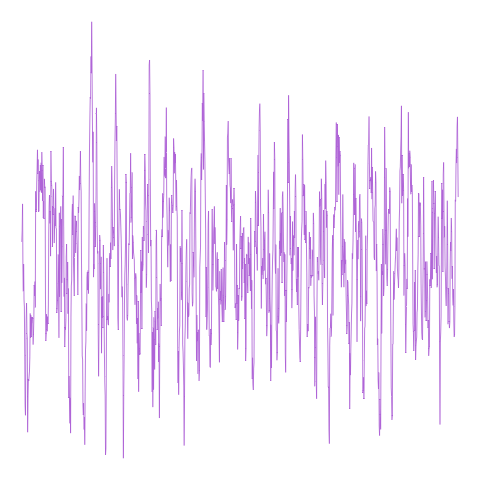

In [8]:
%%R -i seed_region_TS

seed_region_TS %>% 
    ggplot(data=., mapping=aes(x=Timepoint, y=BOLD_Signal)) +
    geom_line(linewidth=0.4, color="#be7edf") +
    theme_void() +
    theme(legend.position="none") 

# ggsave("../SPIs/figure_drafting/left_lateral_occipital_TS.svg", width=4, height=1, units="in", dpi=300)

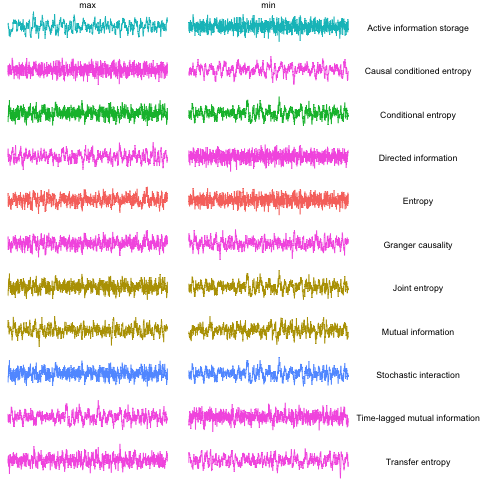

In [9]:
%%R -i min_max_TS_data 

min_max_TS_data %>% 
    ggplot(data=., mapping=aes(x=Timepoint, y=BOLD_Signal, color=as.factor(Group_number))) +
    geom_line(linewidth=0.4) +
    facet_grid(Measure_name~variable) +
    theme_void() +
    theme(legend.position="none") 
# ggsave("../SPIs/figure_drafting/info_theory_measures_min_max_TS.svg", width=6, height=12, units="in", dpi=300)

In [9]:
# Shut down the JVM at the end of session
jpype.shutdownJVM() 

## How are the measures correlated?

In [12]:
measure_wise_corrs = mean_measure_value_by_region.pivot(index="region_to", columns="Measure_name", values="mean_value_norm").corr(method="spearman")

measure_wise_corrs_bivar =  mean_measure_value_by_region.query("Measure_name not in ['Active information storage', 'Entropy']").pivot(index="region_to", columns="Measure_name", values="mean_value_norm").corr(method="spearman")

In addition: Warning message:
The input is a data frame-like object, convert it to a matrix. 


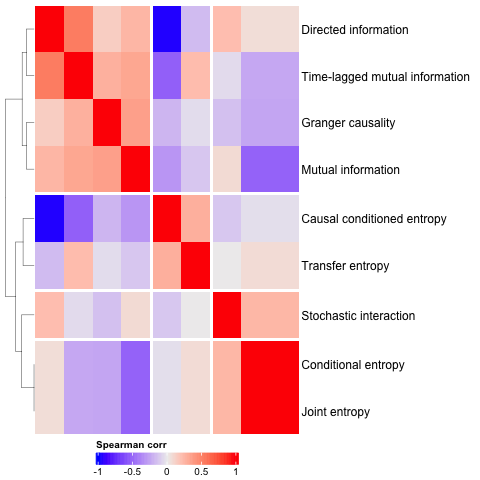

In [14]:
%%R -i measure_wise_corrs,measure_wise_corrs_bivar

# svg("../SPIs/figure_drafting/infotheory_measure_corrs_across_brain_bivar.svg", width=7, height=5, bg=NA)
ht1 <- ComplexHeatmap::Heatmap(measure_wise_corrs_bivar,
                                clustering_method_rows = "ward.D2",
                                clustering_method_columns = "ward.D2",
                                row_names_side = "right",
                                row_dend_side = "left", 
                                row_dend_width = unit(1, "cm"),
                                row_dend_gp = gpar(lwd=unit(0.5, "cm")),
                                row_split = 4,
                                column_split = 3,
                                row_title = NULL,
                                column_title = NULL,
                                show_row_names = TRUE,
                                show_column_names = FALSE,
                                name = "Spearman corr",
                                show_column_dend = FALSE,
                                heatmap_legend_param = list(legend_direction = "horizontal",
                                                            legend_width = unit(5, "cm"))) 

draw(ht1, heatmap_legend_side = "bottom",
    padding = unit(c(2, 2, 2, 2), "mm"),
    background = "transparent")
# dev.off()

### Plot entropy histogram in the brain

In [21]:
this_subject_infotheory_results.head()

,Measure,region_from,region_to,Measure_Type,value,Base_Region,Sample_ID,Measure_name,Group,Group_number,value_norm
0,entropy_kozachenko,lateraloccipital,lateraloccipital,Univariate,1.398085,lateraloccipital,298051,Entropy,Univariate order-independent,1,0.436717
1,AIS_kraskov,lateraloccipital,lateraloccipital,Univariate,0.578941,lateraloccipital,298051,Active information storage,Univariate order-dependent,4,0.759907
2,entropy_kozachenko,entorhinal,entorhinal,Univariate,1.388790,entorhinal,298051,Entropy,Univariate order-independent,1,0.406856
3,AIS_kraskov,entorhinal,entorhinal,Univariate,0.086852,entorhinal,298051,Active information storage,Univariate order-dependent,4,0.474419
4,je_kozachenko,lateraloccipital,entorhinal,Bivariate,2.803320,NaN,298051,Joint entropy,"Bivariate order-independent, undirected",2,0.293381


In [41]:
# Find the min and max value_norm per Measure_name, keeping the region_from and region_to columns

entropy_min_max = (this_subject_infotheory_results
                      .query("Measure_name == 'Entropy'")
                      .groupby("Measure_name")['value_norm']
                      .agg(['min', 'max'])
                      .reset_index()
                      .melt(id_vars="Measure_name", var_name="variable", value_name="value_norm")
                      .merge(this_subject_infotheory_results, on=["Measure_name", "value_norm"], how="left")
                      .sort_values(['Measure_name', 'variable'])
)
entropy_min_region = entropy_min_max.query("variable == 'min'").region_from.values[0]
entropy_max_region = entropy_min_max.query("variable == 'max'").region_from.values[0]
entropy_min_TS = subject_TS_data_melted.query(f"Brain_Region == 'ctx-lh-{entropy_min_region}'").assign(Entropy = "min")
entropy_max_TS = subject_TS_data_melted.query(f"Brain_Region == 'ctx-lh-{entropy_max_region}'").assign(Entropy = "max")

entropy_min_max_df = pd.concat([entropy_min_TS, entropy_max_TS])

entropy_min_max_df.head()

,Timepoint,Brain_Region,BOLD_Signal,Entropy
16800,1,ctx-lh-parahippocampal,-1.120140,min
16801,2,ctx-lh-parahippocampal,0.999691,min
16802,3,ctx-lh-parahippocampal,-0.418708,min
16803,4,ctx-lh-parahippocampal,0.858034,min
16804,5,ctx-lh-parahippocampal,0.796628,min


In [58]:
%%R -i entropy_min_max_df

entropy_min_max_df %>%
    group_by(Entropy) %>%
    mutate(mean_x = mean(BOLD_Signal)) %>% 
    ggplot(data=., mapping=aes(x=BOLD_Signal, fill=Entropy)) +
    # geom_histogram(position='identity', alpha=0.7, bins=50) +
    geom_density(position='identity', alpha=0.7) +
    scale_y_continuous(expand=c(0,0)) +
    facet_wrap(Entropy ~ ., nrow=1, scales='fixed') +
    scale_fill_manual(values=c("min"="#FFEFED", "max" = "#F9766D")) +
    xlab("BOLD signal") +
    geom_vline(aes(xintercept=mean_x), linetype="dashed", size=0.5) +
    theme(legend.position='none',
          strip.text = element_blank(),
          strip.background = element_blank())
ggsave('../SPIs/figure_drafting/entropy_min_max_TS_density.svg', width=6, height=2, units="in", dpi=300)

entropy_min_TS